# Introduction to moku-nn

In this basic tutorial we will go over the fundamentals of using the provided neural network library for training a neural network which can be deployed on the Moku. This library uses the [Tensorflow](https://www.tensorflow.org/) implementation of [Keras](https://www.tensorflow.org/guide/keras) to instill best practices for deploying an FPGA based neural network on the Moku. In this example, we will train a basic model to output a sine wave as a function of the input voltage on a given channel. This could be used to train a custom output response of the model as a function of input voltage (i.e. a complicated function that has no easy closed form expression), but here it will simply serve as an illustrative example.

<div class="alert alert-block alert-info">
<b>Tip:</b> For more experienced users, it is completely possible to use your favourite library to create your models for export to the Moku. In this case, however, it will be necessary to implement all of the relevant layer and output clipping, data scaling and layer constraints yourself.
</div>

In [1]:
# import the relevant libraries for this example
import numpy as np
import matplotlib.pyplot as plt

from moku.nn import LinnModel, save_linn
# set the seed for repeatability
np.random.seed(7)

# Data Generation

The first step is to generate a data et that we will use to train the model. In this case we will generate an array of points from $0$ to $2\pi$ which will allow us to define "frequency" conveniently. In this case, we want our outputs to be a sin wave of frequency=5, such that if we were to sweep the voltage on the input of the Moku, we should output a sine wave with 5 cycles.

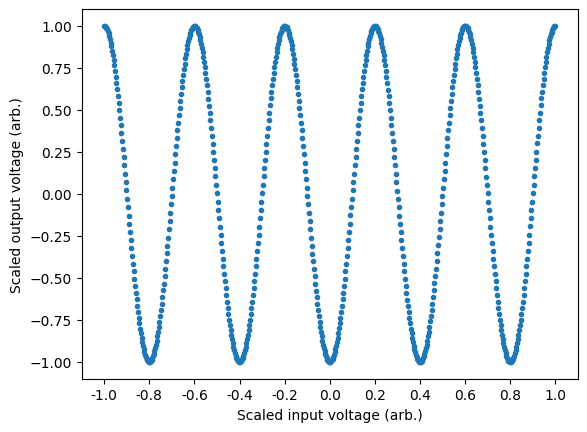

In [74]:
# generate some very basic training data
X = np.arange(0, np.pi*2, 0.01)
Y = np.cos(X*5)

plt.plot(X, Y, '.')
plt.xticks(np.linspace(0, np.pi*2, 11), labels=["%.1f" % i for i in np.linspace(-1, 1, 11)])
plt.xlabel('Scaled input voltage (arb.)')
plt.ylabel('Scaled output voltage (arb.)')
plt.show()

For best practice we wish to use the full range of the Moku's inputs to avoid quantisation errors. During export of the model, it will be assumed that the range of the inputs and outputs is `[-1, 1]`, with anything outside of this range being clipped. This assumption ensures at export that the full bit depth of the Moku is used to try and avoid quantisation errors. In this example, this assumes that the input voltage on the x-axis is being swept between the positive and negative limits of the Moku's input voltage range. Similarly, the output voltage is also assumed to be outputting from the negative and positive limits of the Moku's output voltage range. Maximum utilisation of the Moku bit depth will ensure that quantisation errors are minimised when exporting the floating point models to fixed point arrays required by the FPGA. As we will see in the next section, the quantised model implementation of the moku-nn library takes care of this process automatically, allowing you to work in the native data space.

To train the model correctly we will generate a training and validation set of data. The validation data is not used during the training process and allows us to measure the performance of the model without falling victim to overfitting. We will reserve 10% of the data for validaiton and randomly select samples from the training set to construct our validation set.

<div class="alert alert-block alert-info">
<b>Note:</b> You can skip this step and just pass the `validation_split` parameter to the `fit_model` function. Doing this explicitly allows us to plot the validation data below for interest and education.
</div>

In [75]:
# get 10% of the random indices 
data_indices = np.arange(0, len(X), 1)
np.random.shuffle(data_indices)
val_length = int(len(X)*0.1) 
train_indices = data_indices[val_length:]
val_indices = data_indices[:val_length]

# separate the training and validation sets
train_X = X[train_indices]
train_Y = Y[train_indices]
val_X = X[val_indices]
val_Y = Y[val_indices]

# Defining the model

Now that we have defined the training data we need to define a model which we will then subsequently train. A neural network is made of succesive layers of connected neurons that implement a generally non-linear mapping of a linear transform: $A(Wx + b)$, where $W$ is the weight matrix, $x$ is an input vector, $b$ is a bias vector and $A$ is the activation function. By successively stacking and connecting arbitrarily large numbers of artificial neurons, a neural network becomes a unviersal approximator. While there are many different types of neural networks, the Moku FPGA currently only supports densely connected feedforward networks. More information on these type of networks, otherwise known as multilayer perceptrons, can be found here: [Goodfellow-Ch6](https://www.deeplearningbook.org/contents/mlp.html).

We start by instantiating the quantised model instance and passing the training data we created previously:

In [76]:
# create the quantised model object
quant_mod = LinnModel()
quant_mod.set_training_data(training_inputs=train_X.reshape(-1,1), training_outputs=train_Y.reshape(-1,1))

Note that we are using unscaled values for the training data, instead this will be taken care of by the model object. Additionally we reshape the data to reflect that we have N number of training examples of size 1. In general, training data should allow for the mapping $(N, M)\mapsto(N, K)$ where N is the number of training examples, M is the input feature dimension and K is the output feature dimension. In this case we are looking to map $X \mapsto Y$ where both X and Y have shape (N, 1).

We need to define the model structure that we will use to represent the functional mapping. To do this we will define a model with 3 intermediate layers of size 32, where each layer uses the activation function ReLU. We provide a model definition as a list of tuples, where each tuple take the form: `(layer_size, activation)`. We will use the `show_summary` flag to map to output the constructed model summary.

In [77]:
# model definition
model_definition = [(32, 'relu'), (32, 'relu'), (32, 'tanh'), (1, 'linear')]

# build the model
quant_mod.construct_model(model_definition, show_summary=True)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_51            │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_52            │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_53            │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_54            │ (None, 1)              │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

Here we can see our dense layers that match the size that we defined. There are a number of intermediate layers listed as `output_clip_layer` which can be ignored. These layers are a byproduct of the quantisation for the Moku implmentation and are automatically added by the quantised model.

# Training the model

Now that we have defined our model, we need to train it so that it will represent our desired mapping. This is as simple as calling the `fit_model()` function with a few simple arguments. We will allow our model to train for 600 epochs (training steps) and will pass our validation data that we used earlier.

<div class="alert alert-block alert-info">
<b>Tip:</b> For those familiar with Keras, keyword arguments can be passed to the Keras 'fit' function via the 'fit_model' function.
</div>

In [78]:
# fit the model
history = quant_mod.fit_model(epochs=1000, validation_data=(val_X.reshape(-1,1), val_Y.reshape(-1,1)))

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5099 - val_loss: 0.4629
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5233 - val_loss: 0.4943
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4758 - val_loss: 0.4779
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5120 - val_loss: 0.4759
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4855 - val_loss: 0.4635
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4719 - val_loss: 0.5107
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4754 - val_loss: 0.4832
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4632 - val_loss: 0.4964
Epoch 9/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4765 - val_loss: 0.4914
Epoch 10/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4674 - val_loss: 0.4874
Epoch 11/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4433 - val_loss: 0.5148
Epoch 12/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

We can use the returned history object to view the training and validation loss as a function of the training epochs. Below we can see that initially the validation loss increases. This is not a symptom of overfitting, but rather a local minimum associated with the training process. As training continues we can see that again the validation loss reduces and we end up with a model that has generalised to the training data.

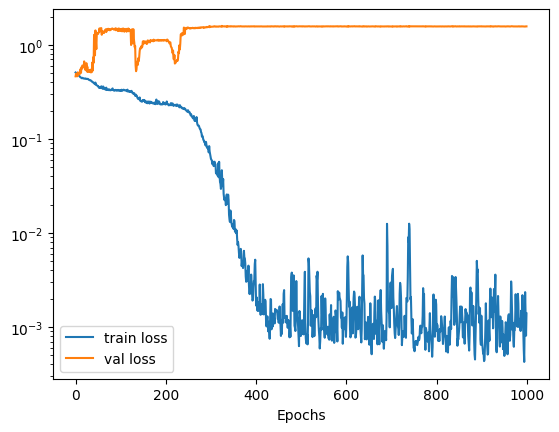

In [79]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

We can view the performance of our model on our data by plotting the models predictions. In general, training an accurate model will be a function of many variables including choice of activation function, number of layers, number of neurons and the structure of the training data. In this case we see some artifacts of the training process as the model is not 100% accurate. This could be improved by tweaking the aforementioned parameters.

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


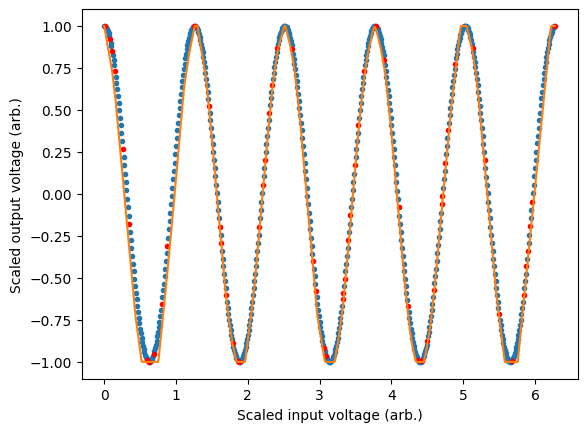

In [80]:
# use the model to predict the output
preds = quant_mod.predict(X)

# plot the training, validation and model predictions
plt.plot(train_X, train_Y, '.')
plt.plot(val_X, val_Y, 'r.')
plt.plot(X, preds)
plt.xlabel('Scaled input voltage (arb.)')
plt.ylabel('Scaled output voltage (arb.)')
plt.show()

# Exporting the model

We can export the model to a format that can be read by the Moku using the function `save_linn()`. This will export our trained model to a json file that can be read in by the Moku neural network instrument. 

In [81]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='simple_sine_model.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 109 cycles
